In [745]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model

In [698]:
import warnings
warnings.filterwarnings("ignore")

In [699]:
g1 = ['West Bengal', 'Telangana','Bihar', 'Punjab', 'Odisha', 'Jharkhand', 'Haryana', 'Chhattisgarh', 'Andhra Pradesh']
g2 = ['Uttar Pradesh', 'Maharashtra']
g3 = ['Rajasthan', 'Madhya Pradesh', 'Karnataka', 'Gujarat', 'Tamil Nadu']
g4 = ['Uttarakhand', 'Sikkim','Arunachal Pradesh','Assam','Manipur','Meghalaya','Mizoram','Nagaland','Tripura', 'Kerala', 'Goa', 'Delhi', 'Jammu and Kashmir', 'Himachal Pradesh', 'Chandigarh']

all_groups = g1 + g2 + g3 + g4

In [700]:
sol = pd.read_csv('SOL_State.csv')
sol['date'] = pd.to_datetime(sol['date'])
sol = sol.pivot(index='date', columns='region', values='sol')
sol = sol[all_groups] 

In [701]:
sol.index = pd.to_datetime(sol.index)
date_range = pd.date_range(start=sol.index.min().date(), end=sol.index.max().date())

missing_dates = []
for date in date_range:
    if date not in sol.index.date:
        missing_dates.append(date)

for missing_date in missing_dates:
    sol.loc[missing_date] = 0

sol.sort_index(inplace=True)

In [702]:
for i in range(len(sol.columns)):
    for j in range(len(sol)):
        if sol.iloc[j,i]==0:
            sol.iloc[j,i] = sol.iloc[j-1,i]

In [703]:
for col in sol.columns:
    Q1 = sol[col].quantile(0.25)
    Q3 = sol[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (sol[col] < lower_bound) | (sol[col] > upper_bound)

    idx = sol.columns.get_loc(col)

    for i in range(len(sol)):
        if sol.iloc[i,idx] > upper_bound:
            sol.iloc[i,idx] = (sol.iloc[i-1,idx]+sol.iloc[i+1,idx])/2

In [704]:
clus1 = pd.read_csv('cluster1.csv')
clus2 = pd.read_csv('cluster2.csv')
clus3 = pd.read_csv('cluster3.csv')
clus4 = pd.read_csv('cluster4.csv')

In [705]:
date_range = pd.date_range(start='2013-04-01', end='2023-12-31')
clus1['date'] = date_range
clus2['date'] = date_range
clus3['date'] = date_range
clus4['date'] = date_range

clus1.set_index('date', inplace=True)
clus2.set_index('date', inplace=True)
clus3.set_index('date', inplace=True)
clus4.set_index('date', inplace=True)

In [706]:
elec_g1, sol_g1 = clus1['ele'], sol[g1].sum(axis=1)
elec_g2, sol_g2 = clus2['ele'], sol[g2].sum(axis=1)
elec_g3, sol_g3 = clus3['ele'], sol[g3].sum(axis=1)
elec_g4, sol_g4 = clus4['ele'], sol[g4].sum(axis=1)

elec_g1.name = 'ele'
sol_g1.name = 'sol_g1'

elec_g2.name = 'ele'
sol_g2.name = 'sol_g2'

elec_g3.name = 'ele'
sol_g3.name = 'sol_g3'

elec_g4.name = 'ele'
sol_g4.name = 'sol_g4'

In [707]:
df_g1 = pd.merge(sol_g1, elec_g1, on='date', how='inner')
df_g2 = pd.merge(sol_g2, elec_g2, on='date', how='inner')
df_g3 = pd.merge(sol_g3, elec_g3, on='date', how='inner')
df_g4 = pd.merge(sol_g4, elec_g4, on='date', how='inner')

In [708]:
actual_elec = pd.read_csv('elec1_new.csv')
actual_elec['Date'] = pd.to_datetime(actual_elec['Date'], format="%d.%m.%y")
actual_elec = actual_elec[(actual_elec['Date'] >= '2024-01-01') & (actual_elec['Date'] <= '2024-02-29')]
actual_elec.set_index('Date', inplace=True)
actual_elec = actual_elec[all_groups]

actual_g1 = actual_elec[g1].sum(axis=1)
actual_g2 = actual_elec[g2].sum(axis=1)
actual_g3 = actual_elec[g3].sum(axis=1)
actual_g4 = actual_elec[g4].sum(axis=1)

In [709]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1

        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix,:], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [710]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [750]:
def forecast_state(df, actual, epochs): 

    split_index = int(len(df)*0.8)
    train, test = df[:split_index], df[split_index:]


    scalers = {}
    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(0,1))
        train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
        scalers['scaler'+i] = scaler

    for i in test.columns:
        scaler = scalers['scaler'+i]
        test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))


    n_steps_in, n_steps_out = 360, 60

    X_train, y_train = split_sequences(train.values, n_steps_in, n_steps_out)
    X_test, y_test = split_sequences(test.values, n_steps_in, n_steps_out)

    n_features, n_seq, n_steps_in = X_train.shape[2], 12, 30

    X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps_in, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps_in, n_features))


    # model = Sequential()
    # model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_in, n_features)))
    # model.add(Flatten())
    # model.add(Dense(n_steps_out))

    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_in, n_features)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(n_steps_out))

    plot_model(model, to_file='C:\DARSHINI\VIT\SEMESTER_8 Winter(23-24)\Research Paper\images\cluster2&3.png', show_shapes=True, show_layer_names=True, 
           expand_nested=True, dpi=300, rankdir='TB', 
           layer_range=None, 
           show_dtype=False)
    
    print(model.summary())

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    history = model.fit(X_train, y_train, epochs=epochs)
    plt.plot(history.history['loss'])
    plt.show()


    predictions = model.predict(X_test)
    print(predictions)


    y_org = scalers['scalerele'].inverse_transform(y_test)
    pred_org = scalers['scalerele'].inverse_transform(predictions)

    plt.plot(y_org[-1], label='Actual', color='blue')
    end_index = len(y_org[-1])
    plt.plot(range(end_index, end_index+len(pred_org[-1])), pred_org[-1], label='Forecasted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Forecasted values')
    plt.legend()
    plt.show()


    
    plt.plot(actual.values[:60], label='Actual', color='blue')
    plt.plot(pred_org[-1], label='Forecasted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Forecasted')
    plt.legend()
    plt.show()

    print("RMSE: ", math.sqrt(mean_squared_error(actual.values[:60], pred_org[-1])))
    print("MAPE: ", mean_absolute_percentage_error(actual.values[:60], pred_org[-1]))

    return pred_org[-1]

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_32 (ConvLSTM2D)  (None, 1, 29, 64)        34048     
                                                                 
 flatten_60 (Flatten)        (None, 1856)              0         
                                                                 
 dense_74 (Dense)            (None, 256)               475392    
                                                                 
 dense_75 (Dense)            (None, 60)                15420     
                                                                 
Total params: 524,860
Trainable params: 524,860
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
86/86 [==============================] - 20s 190ms/step - loss: 0.0938 - root_mean_squared_error: 0.3063
Epoch 2/300
86/86 [==============================] - 16s 

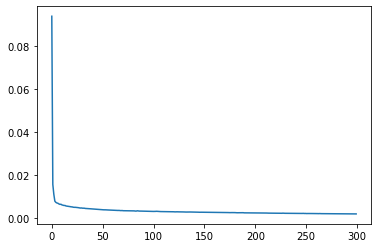

12/12 [==============================] - 3s 55ms/step
[[0.26730463 0.24887894 0.28244835 ... 0.4956517  0.46726176 0.5244391 ]
 [0.28163874 0.26613155 0.28753608 ... 0.4898548  0.4588923  0.51398826]
 [0.29905385 0.27137104 0.27086294 ... 0.47949854 0.46166    0.505672  ]
 ...
 [0.47959736 0.45762452 0.47908393 ... 0.5099392  0.524011   0.57178843]
 [0.4605899  0.4429328  0.4647583  ... 0.53132486 0.53077465 0.55879414]
 [0.45837733 0.41681036 0.43035313 ... 0.52345324 0.511133   0.5450287 ]]


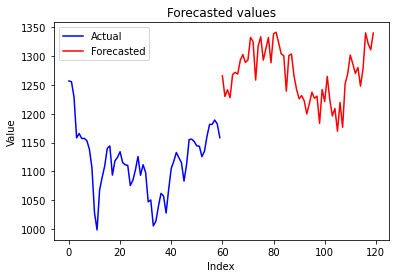

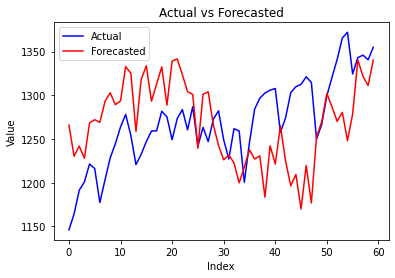

RMSE:  64.7885779397299
MAPE:  4.219199139852245


In [712]:
forecast_state(df_g1, actual_g1, 300)

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_49 (ConvLSTM2D)  (None, 1, 29, 64)        34048     
                                                                 
 flatten_77 (Flatten)        (None, 1856)              0         
                                                                 
 dense_99 (Dense)            (None, 60)                111420    
                                                                 
Total params: 145,468
Trainable params: 145,468
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1500
86/86 [==============================] - 30s 302ms/step - loss: 0.1055 - root_mean_squared_error: 0.3248
Epoch 2/1500
86/86 [==============================] - 25s 293ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 3/1500
86/86 [==============================] - 25s 285ms/step -

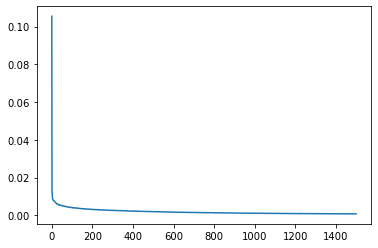

12/12 [==============================] - 1s 79ms/step
[[0.2553455  0.20392135 0.16203354 ... 0.4421391  0.44954523 0.4507045 ]
 [0.2276209  0.15890999 0.13690978 ... 0.45086735 0.46239147 0.4605625 ]
 [0.27136022 0.16644494 0.15980501 ... 0.46775964 0.485334   0.465267  ]
 ...
 [0.54169685 0.55259895 0.5884348  ... 0.27938586 0.25828192 0.2538878 ]
 [0.5647133  0.592434   0.6153252  ... 0.24412276 0.2633991  0.25413868]
 [0.5841878  0.6085761  0.6126325  ... 0.25674516 0.30162832 0.2986114 ]]


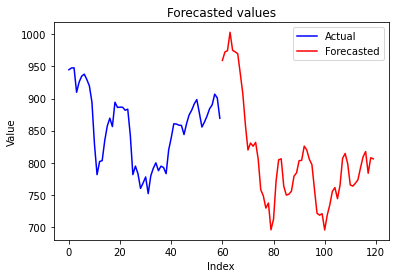

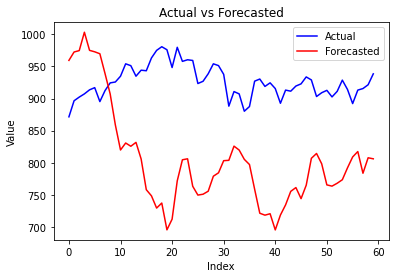

RMSE:  150.64942895365306
MAPE:  15.003539377310815


In [731]:
predictions_g2 = forecast_state(df_g2, actual_g2, 1500)

In [742]:
pred_g2_new = predictions_g2

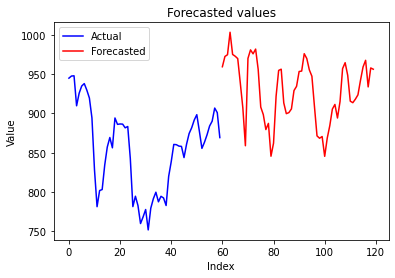

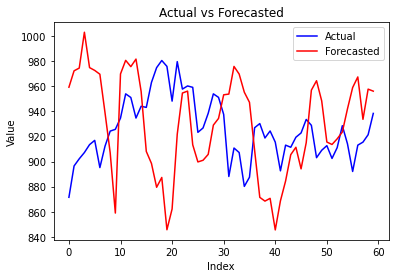

RMSE:  51.98463068700535
MAPE:  4.697518922077794


In [744]:
y_org = df_g2['ele'].tail(60)

plt.plot(y_org.values, label='Actual', color='blue')
end_index = len(y_org)
plt.plot(range(end_index, end_index+len(pred_g2_new)), pred_g2_new, label='Forecasted', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Forecasted values')
plt.legend()
plt.show()



plt.plot(actual_g2.values[:60], label='Actual', color='blue')
plt.plot(pred_g2_new, label='Forecasted', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Forecasted')
plt.legend()
plt.show()

print("RMSE: ", math.sqrt(mean_squared_error(actual_g2.values[:60], pred_g2_new)))
print("MAPE: ", mean_absolute_percentage_error(actual_g2.values[:60], pred_g2_new))


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_34 (ConvLSTM2D)  (None, 1, 29, 64)        34048     
                                                                 
 flatten_62 (Flatten)        (None, 1856)              0         
                                                                 
 dense_78 (Dense)            (None, 256)               475392    
                                                                 
 dense_79 (Dense)            (None, 60)                15420     
                                                                 
Total params: 524,860
Trainable params: 524,860
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
86/86 [==============================] - 23s 207ms/step - loss: 0.1343 - root_mean_squared_error: 0.3665
Epoch 2/300
86/86 [==============================] - 18s 

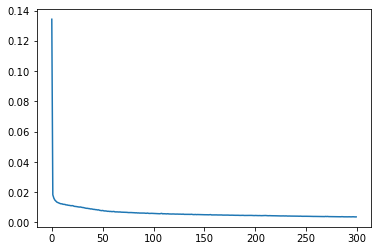

12/12 [==============================] - 1s 46ms/step
[[0.43938023 0.44613096 0.48310432 ... 0.5277175  0.5286514  0.54516584]
 [0.46600553 0.47780696 0.508257   ... 0.548207   0.5260317  0.5339697 ]
 [0.5057011  0.5186112  0.51413596 ... 0.5411097  0.5022147  0.5124093 ]
 ...
 [0.77663654 0.7953724  0.7546112  ... 0.9431334  0.8911159  0.82611614]
 [0.78989965 0.80645144 0.73953444 ... 0.92918617 0.8344033  0.7532286 ]
 [0.7997549  0.7971114  0.7153114  ... 0.88954884 0.767792   0.71017927]]


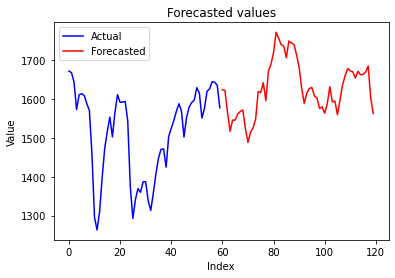

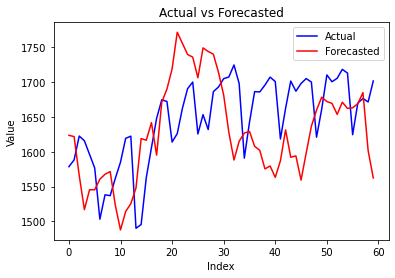

RMSE:  76.19071827574713
MAPE:  3.971468684888631


In [714]:
forecast_state(df_g3, actual_g3, 300)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_44 (ConvLSTM2D)  (None, 1, 29, 64)        34048     
                                                                 
 flatten_72 (Flatten)        (None, 1856)              0         
                                                                 
 dense_94 (Dense)            (None, 60)                111420    
                                                                 
Total params: 145,468
Trainable params: 145,468
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
86/86 [==============================] - 21s 198ms/step - loss: 0.0989 - root_mean_squared_error: 0.3145
Epoch 2/2000
86/86 [==============================] - 17s 198ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410
Epoch 3/2000
86/86 [==============================] - 19s 224ms/step -

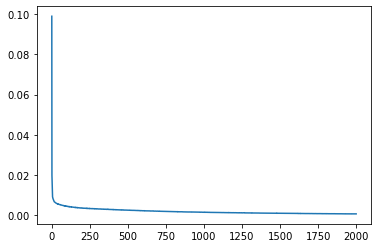

12/12 [==============================] - 1s 69ms/step
[[0.39122418 0.43724245 0.4015513  ... 0.5449463  0.5513822  0.561705  ]
 [0.38685513 0.39840895 0.4060828  ... 0.548739   0.5628428  0.5794631 ]
 [0.42931896 0.44562733 0.48779696 ... 0.5798493  0.5890012  0.55249536]
 ...
 [0.42940968 0.5183439  0.55364674 ... 0.8011346  0.8133659  0.85900015]
 [0.46567175 0.5398809  0.51553726 ... 0.791211   0.843507   0.85056776]
 [0.46654242 0.53940773 0.5387716  ... 0.81665903 0.8496485  0.84562004]]


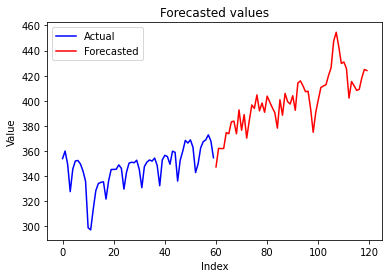

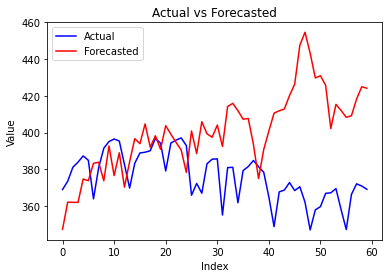

RMSE:  38.35308529012002
MAPE:  8.22034737520509


In [725]:
forecast_state(df_g4, actual_g4, 2000)

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_43 (ConvLSTM2D)  (None, 1, 29, 64)        34048     
                                                                 
 flatten_71 (Flatten)        (None, 1856)              0         
                                                                 
 dense_93 (Dense)            (None, 60)                111420    
                                                                 
Total params: 145,468
Trainable params: 145,468
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
86/86 [==============================] - 21s 201ms/step - loss: 0.1294 - root_mean_squared_error: 0.3597
Epoch 2/1000
86/86 [==============================] - 17s 201ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425
Epoch 3/1000
86/86 [==============================] - 17s 199ms/step -

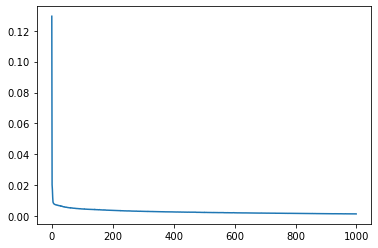

12/12 [==============================] - 1s 49ms/step
[[0.397808   0.4082172  0.48672822 ... 0.5414458  0.5776426  0.600953  ]
 [0.4115218  0.4737498  0.50950325 ... 0.5874872  0.60437024 0.5789784 ]
 [0.47036812 0.5210549  0.5475411  ... 0.6095682  0.5997414  0.5260655 ]
 ...
 [0.5077104  0.54402417 0.609647   ... 0.64010763 0.6937183  0.64303887]
 [0.49737522 0.5496042  0.59443474 ... 0.67891085 0.6603045  0.66117716]
 [0.5113693  0.5324119  0.5910167  ... 0.6531987  0.67034215 0.5843189 ]]


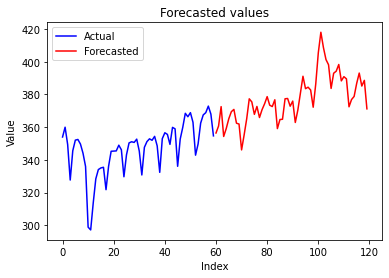

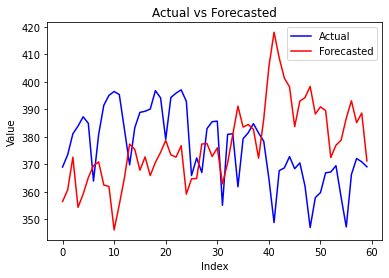

RMSE:  24.367910786007215
MAPE:  5.292554566165432


In [724]:
forecast_state(df_g4, actual_g4, 1000)